In [1]:
import scanpy as sc
adata=sc.read("adata_seurat.h5ad")

In [2]:
sc.pp.filter_genes(adata,min_cells=3)

In [3]:
adata.raw=adata

In [4]:
sc.pp.normalize_total(adata,target_sum=1e3)

In [5]:
sc.pp.log1p(adata)

In [8]:
import scFates as scf

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 2539 over-dispersed features (0:00:01) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



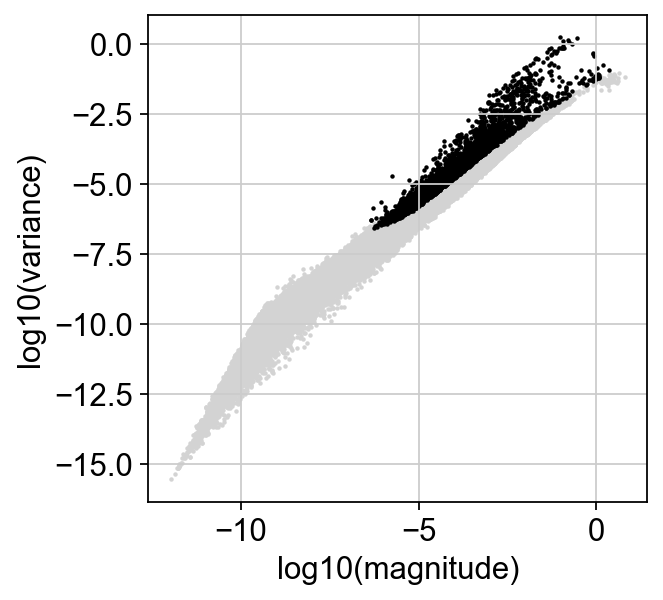

In [9]:
sc.set_figure_params()
scf.pp.find_overdispersed(adata,plot=True)

In [10]:
adata=adata[:,adata.var.highly_variable]
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

sc.tl.umap(adata,method="rapids")

/home/lfaure/tools/scanpy/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/lfaure/miniconda3/envs/rapids-22.06/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


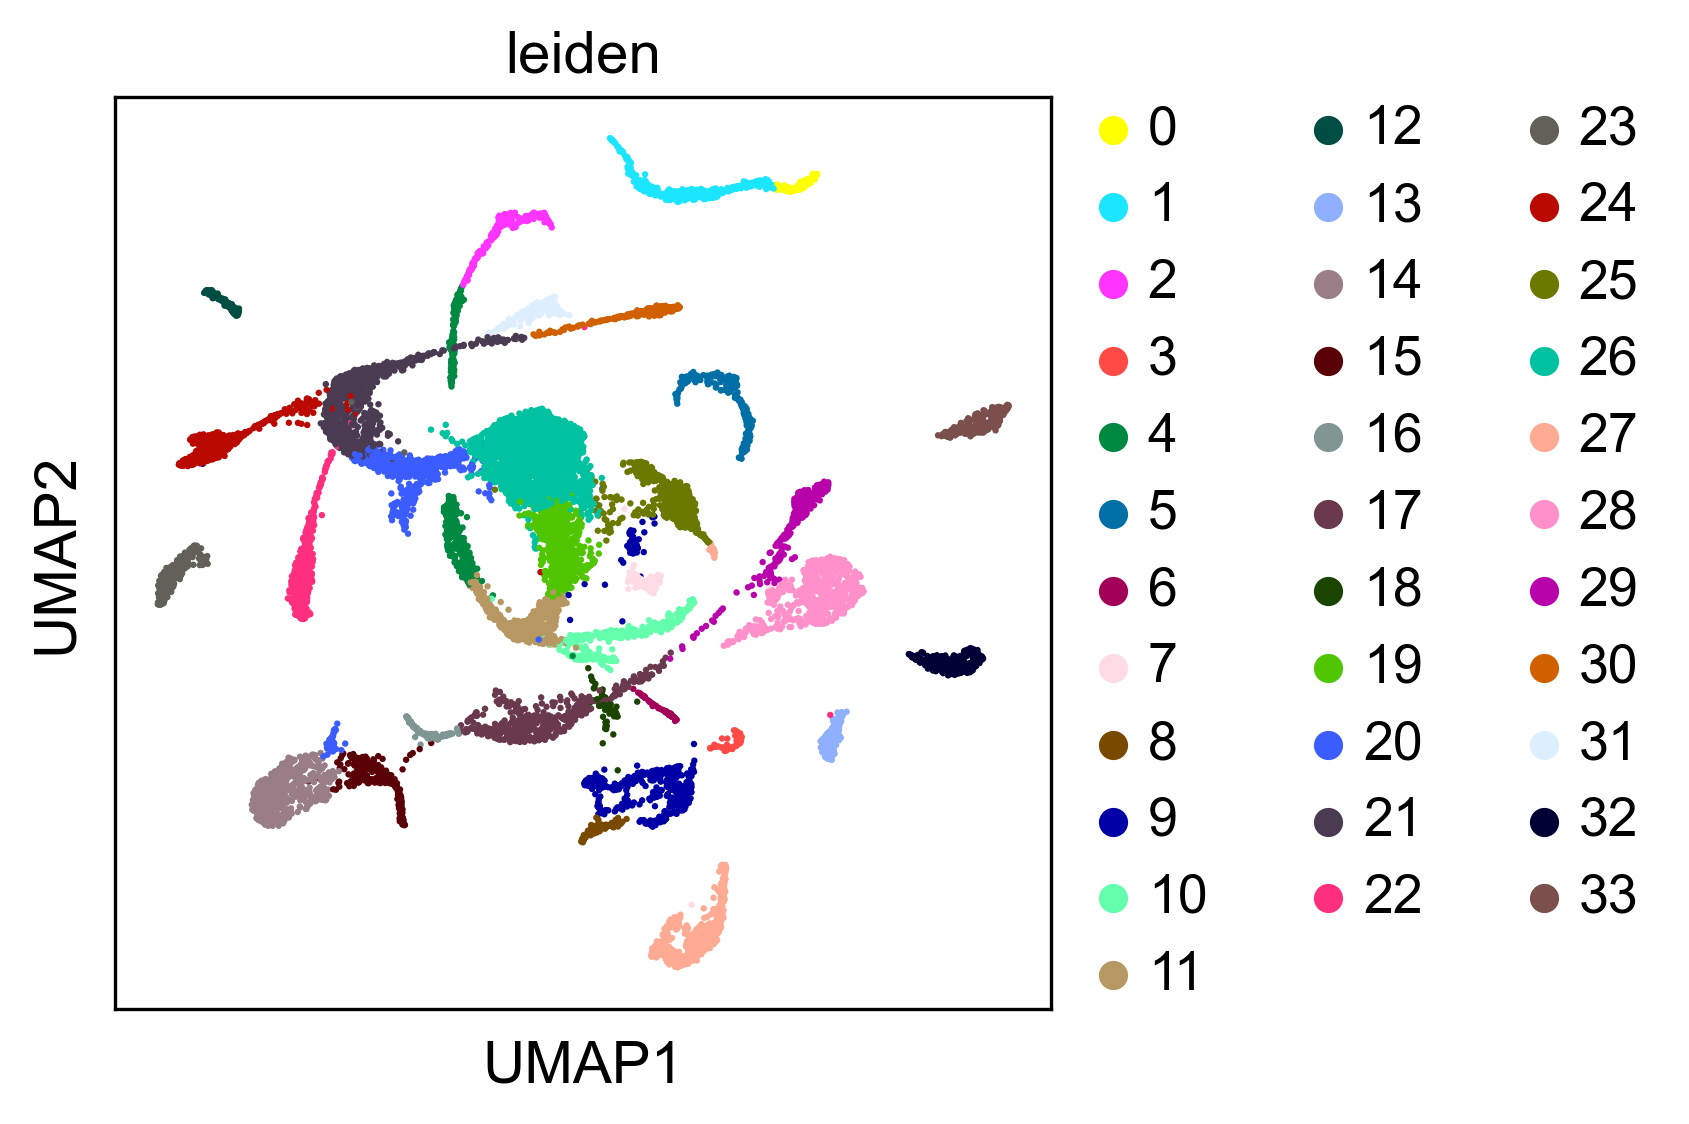

In [11]:
sc.tl.leiden(adata,flavor="rapids")

sc.set_figure_params(dpi=150)
sc.pl.umap(adata,color='leiden')

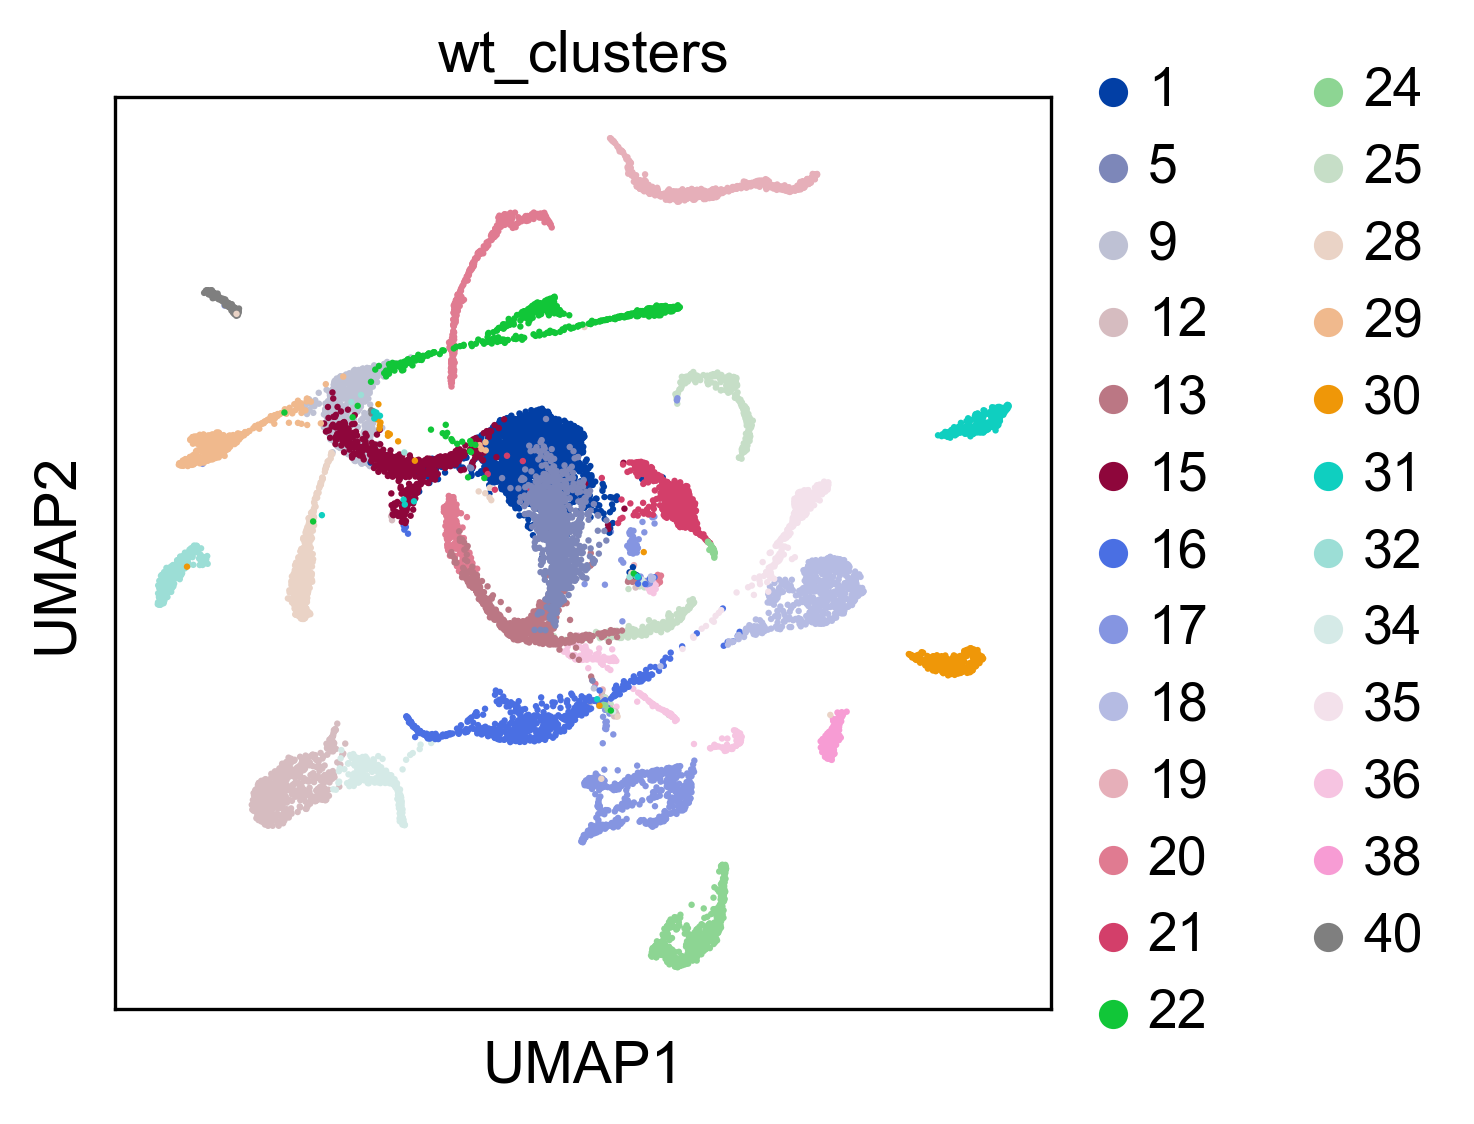

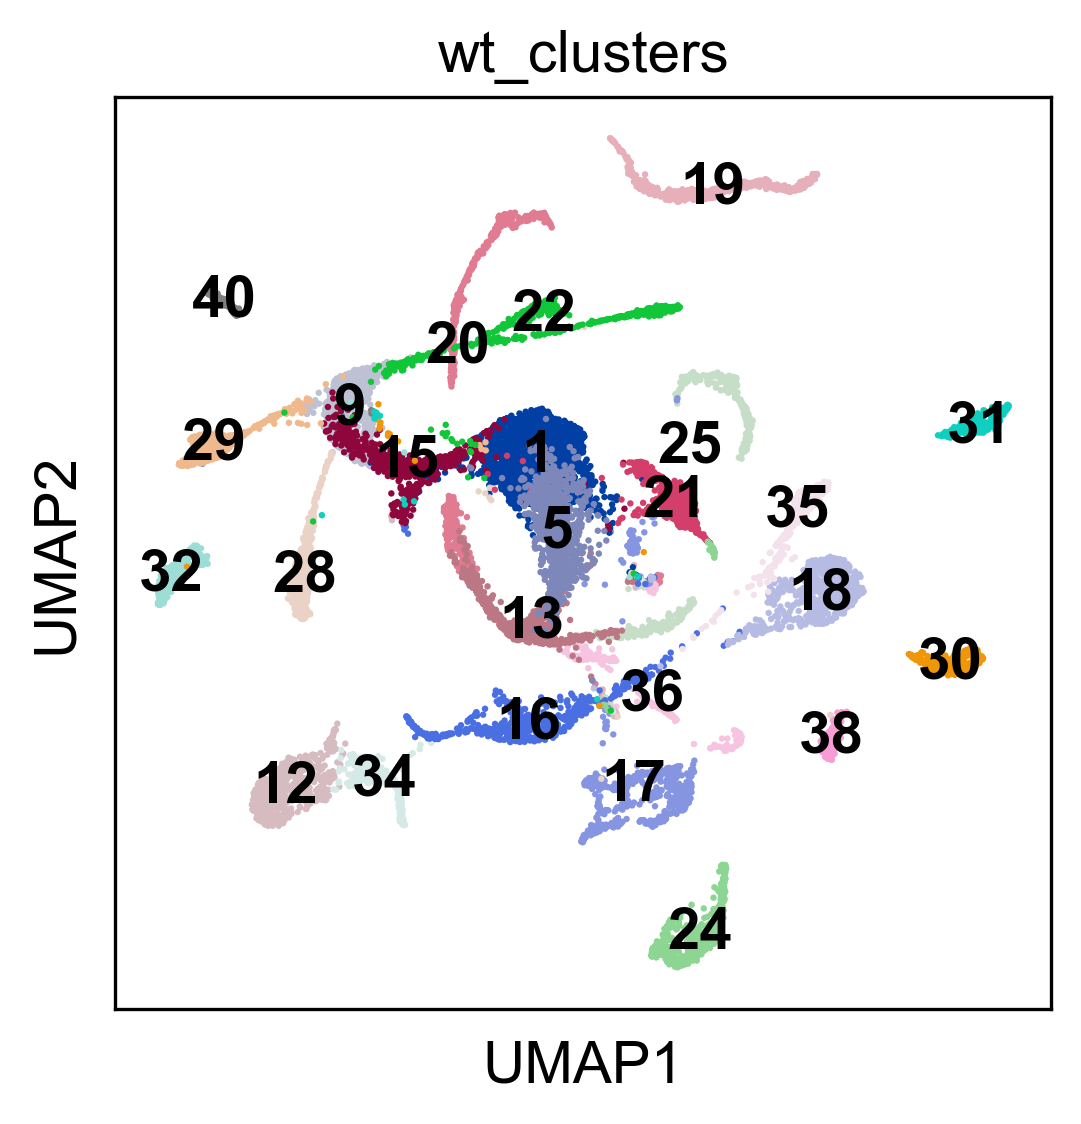

In [13]:
sc.pl.umap(adata,color='wt_clusters')
sc.pl.umap(adata,color='wt_clusters',legend_loc="on data")

/home/lfaure/tools/scanpy/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


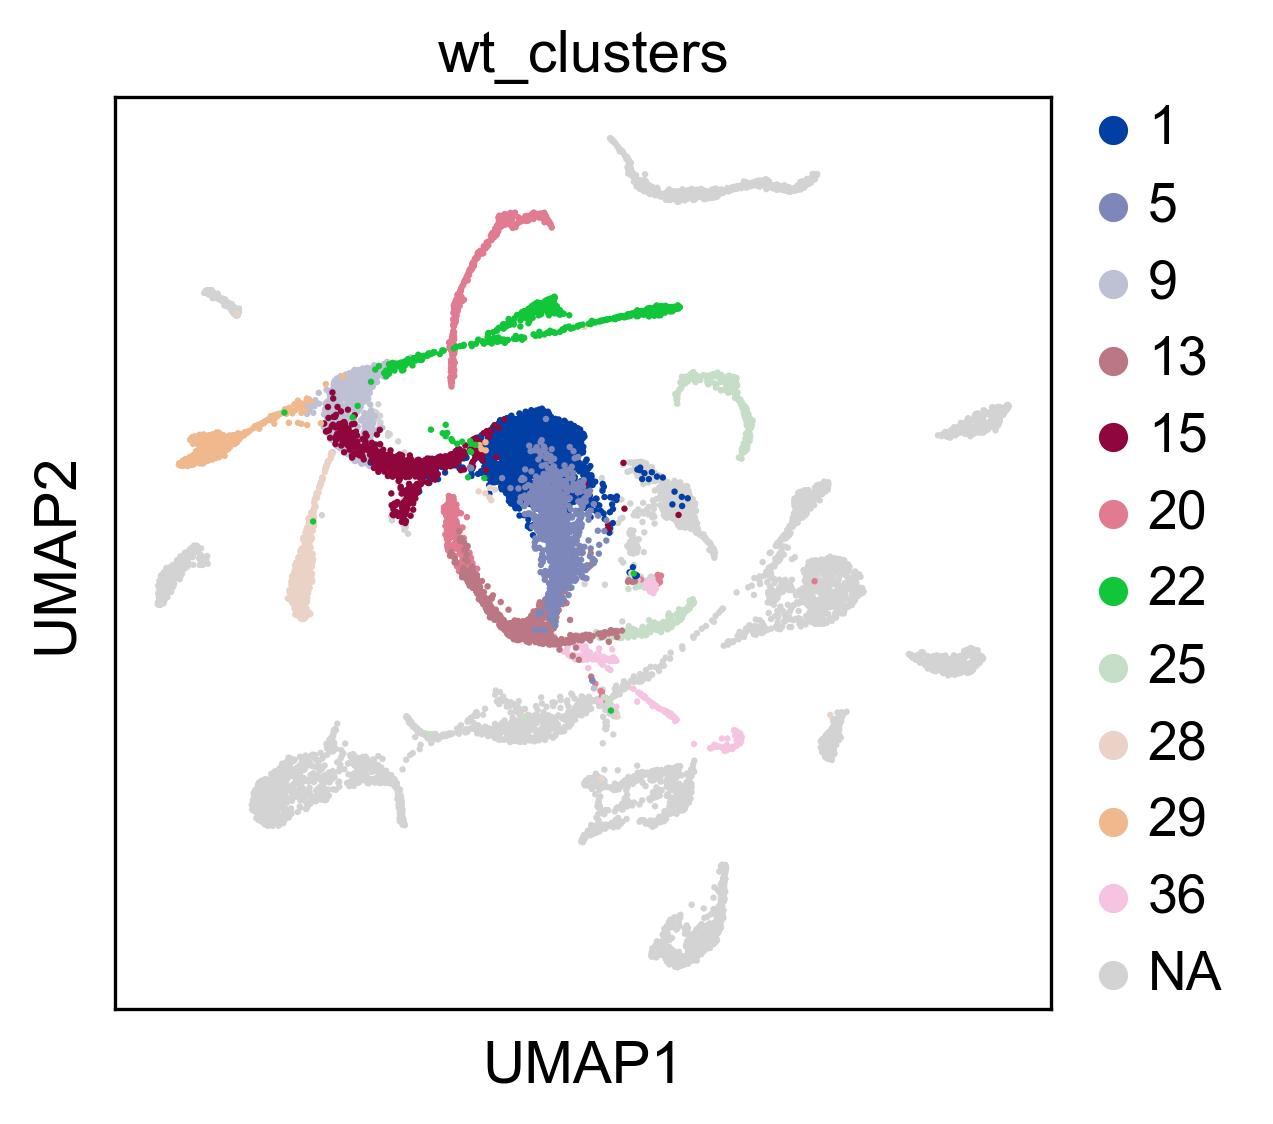

In [15]:
sc.pl.umap(adata,color="wt_clusters",groups=["1","5","13","20","25","20","15","9","22","29","28","36"])

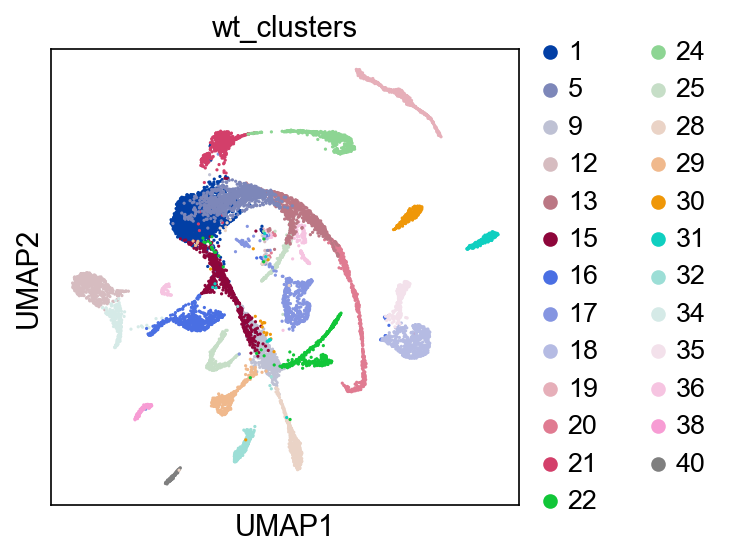

In [16]:
sc.pl.umap(adata,color='wt_clusters')

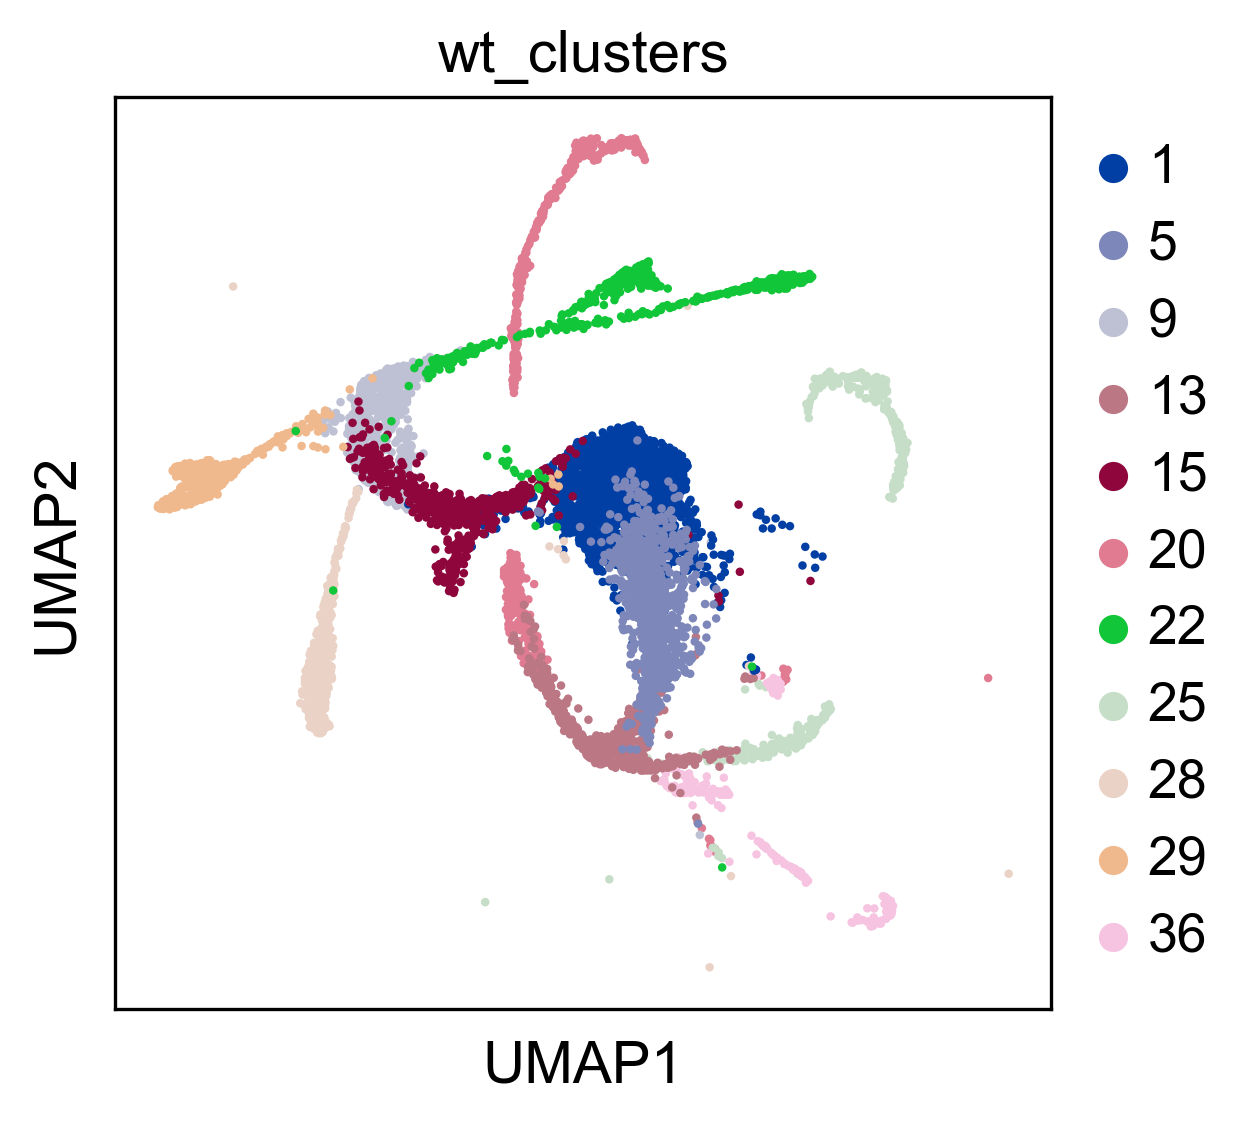

In [16]:
adata=adata[adata.obs.wt_clusters.isin(["1","5","13","20","25","20","15","9","22","29","28","36"])]
sc.pl.umap(adata,color='wt_clusters')

In [18]:
adata_raw=adata.raw.to_adata()

In [19]:
from cellrank.tl.kernels import CytoTRACEKernel
import scvelo as scv
def get_cytotrace(adata):
    sc.pp.filter_genes(adata, min_cells=10)
    scv.pp.normalize_per_cell(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)

    adata.layers["spliced"] = adata.X
    adata.layers["unspliced"] = adata.X
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    ctk = CytoTRACEKernel(adata)
    
get_cytotrace(adata_raw)

Normalized count data: X.
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


/tmp/ipykernel_434539/2406195601.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["CytoTRACE"]=adata_raw.obs.ct_score


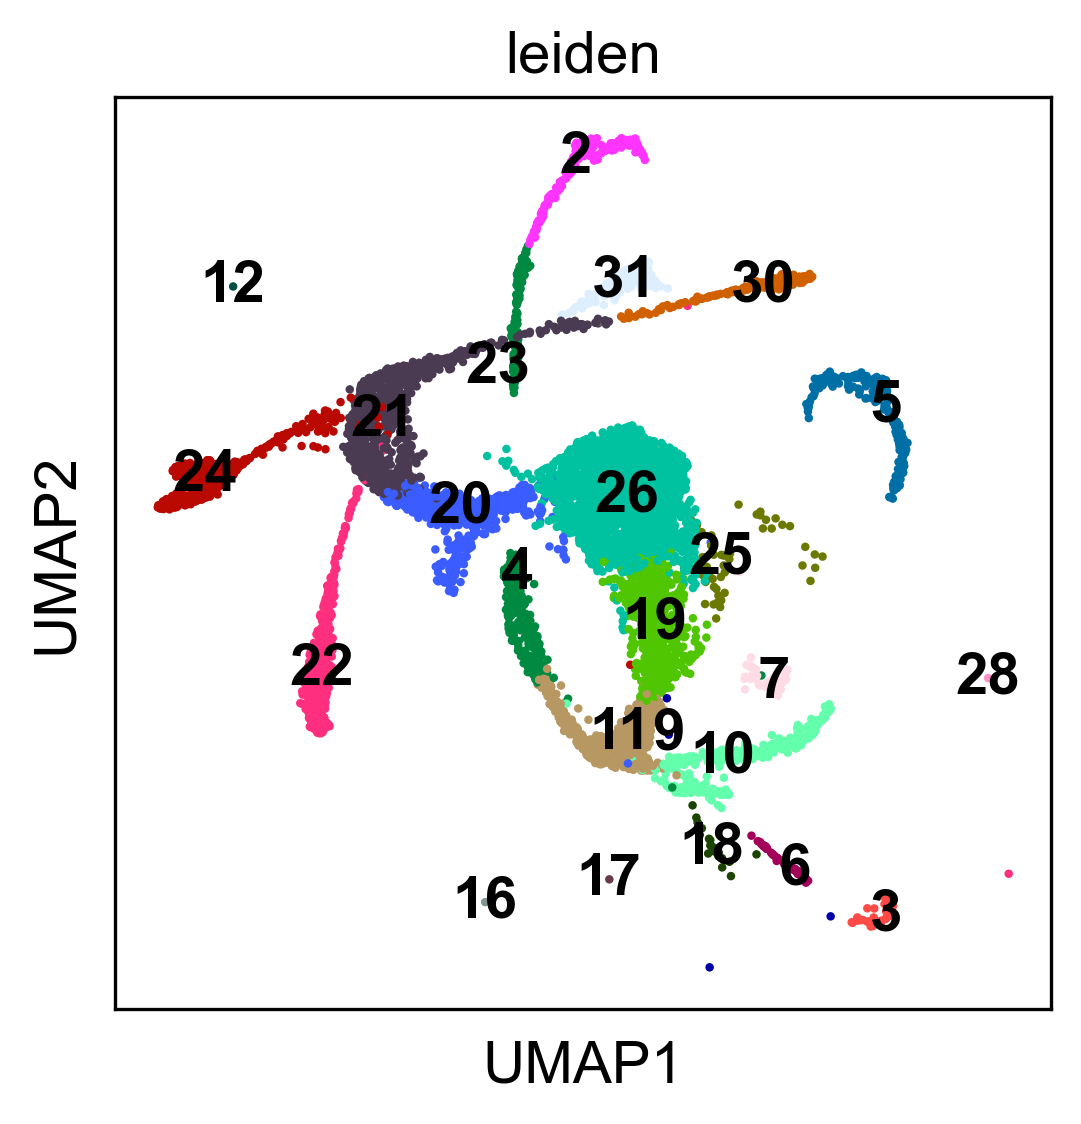

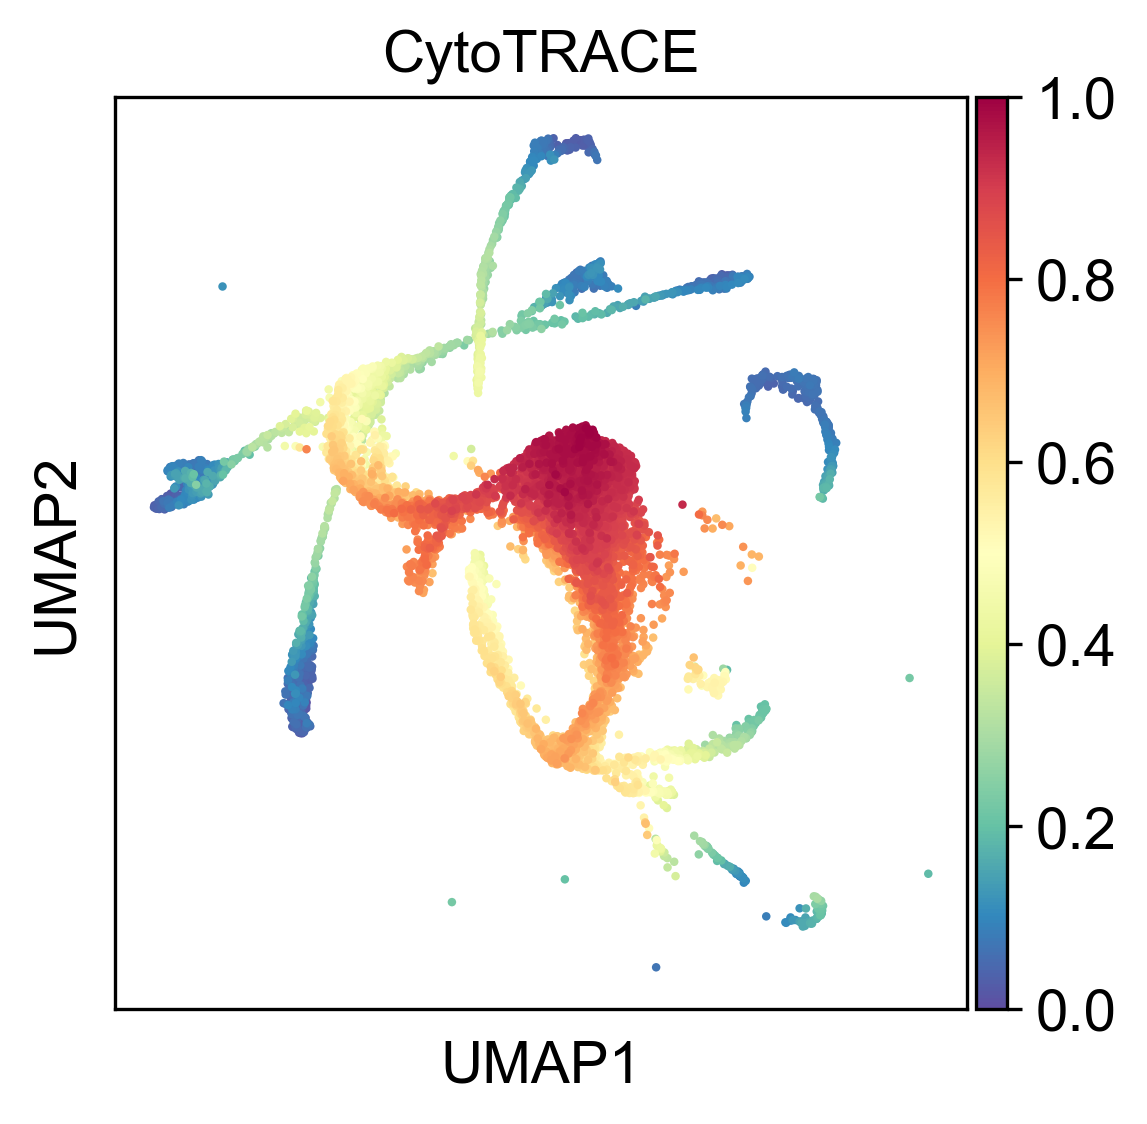

In [20]:
adata.obs["CytoTRACE"]=adata_raw.obs.ct_score
sc.pl.umap(adata,color="leiden",legend_loc='on data')
sc.pl.umap(adata,color="CytoTRACE",cmap="Spectral_r")

In [21]:
scf.pp.diffusion(adata,n_eigs=10)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


Running Diffusion maps 
Determing nearest neighbor graph...
    determining multiscale diffusion space
    finished (0:00:02) --> added 
    .obsm['X_diffusion_multiscale'], multiscale diffusion space.


In [22]:
adata.obsm['X_diffusion_multiscale']

array([[ 3.59576994, -0.9860483 , -0.2035722 , ..., -0.17044846,
        -0.15469534,  0.05038304],
       [ 9.30731444, -6.8644296 , -1.53338408, ...,  1.87273997,
        -0.70137041,  2.10770962],
       [ 9.33100983, -6.93587766, -1.5748053 , ...,  1.82817718,
        -0.70795848,  2.19174576],
       ...,
       [-8.95683791, -1.33086746, -8.12887718, ..., -0.12396091,
        -1.88343475, -0.56102925],
       [-8.91338913, -1.32059396, -8.03385172, ..., -0.1201983 ,
        -1.81715683, -0.53744509],
       [-8.65652146, -1.24235139, -7.83454648, ..., -0.12005936,
        -1.8539394 , -0.56432808]])

In [23]:
sc.pp.neighbors(adata,n_neighbors=30,use_rep="X_diffusion_multiscale")

In [29]:
sc.tl.draw_graph(adata,init_pos="X_diffusion_multiscale",method="rapids")

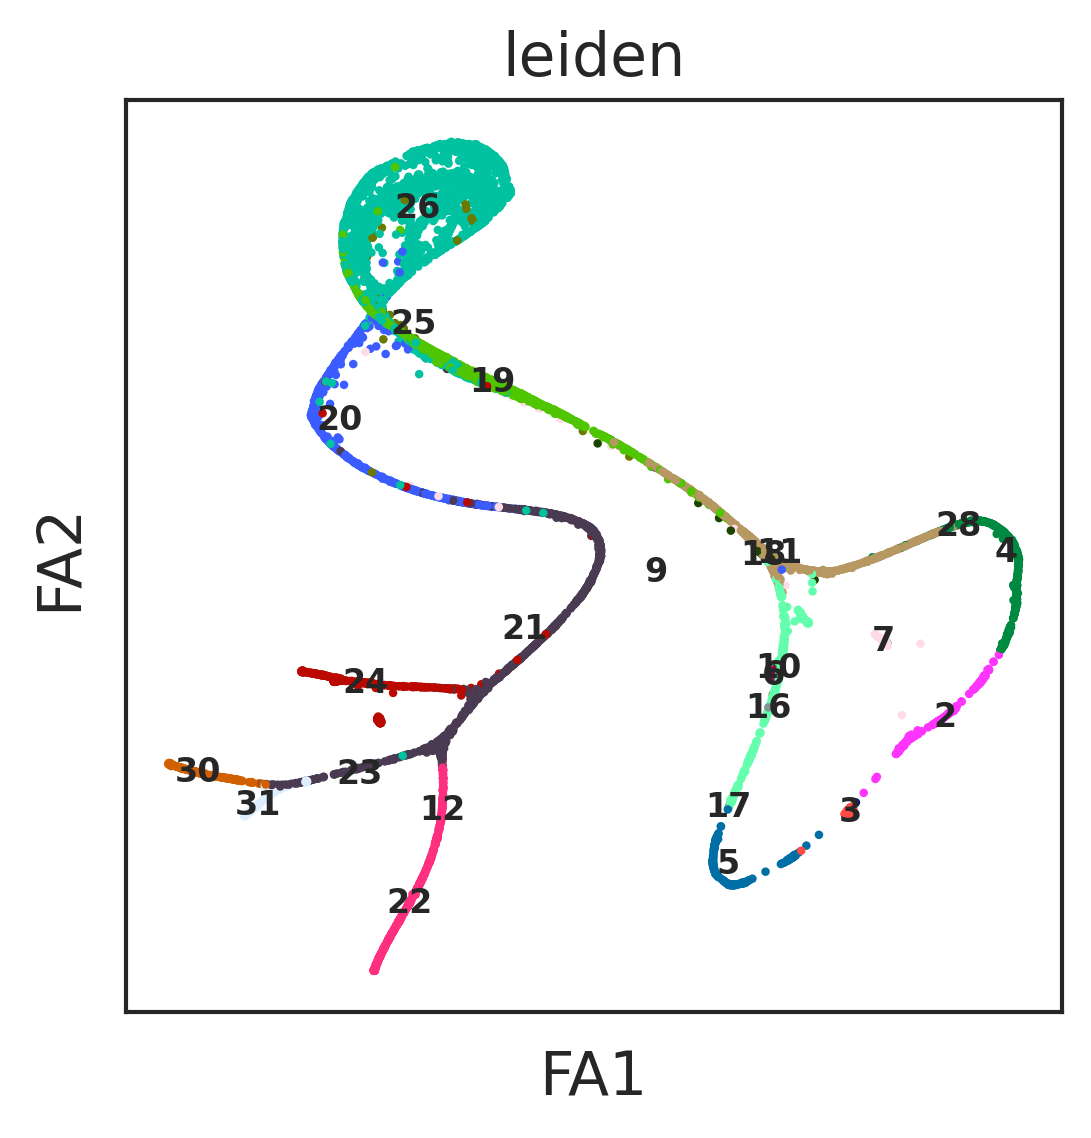

In [30]:
sc.pl.draw_graph(adata,color='leiden',legend_loc='on data',legend_fontsize=8)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


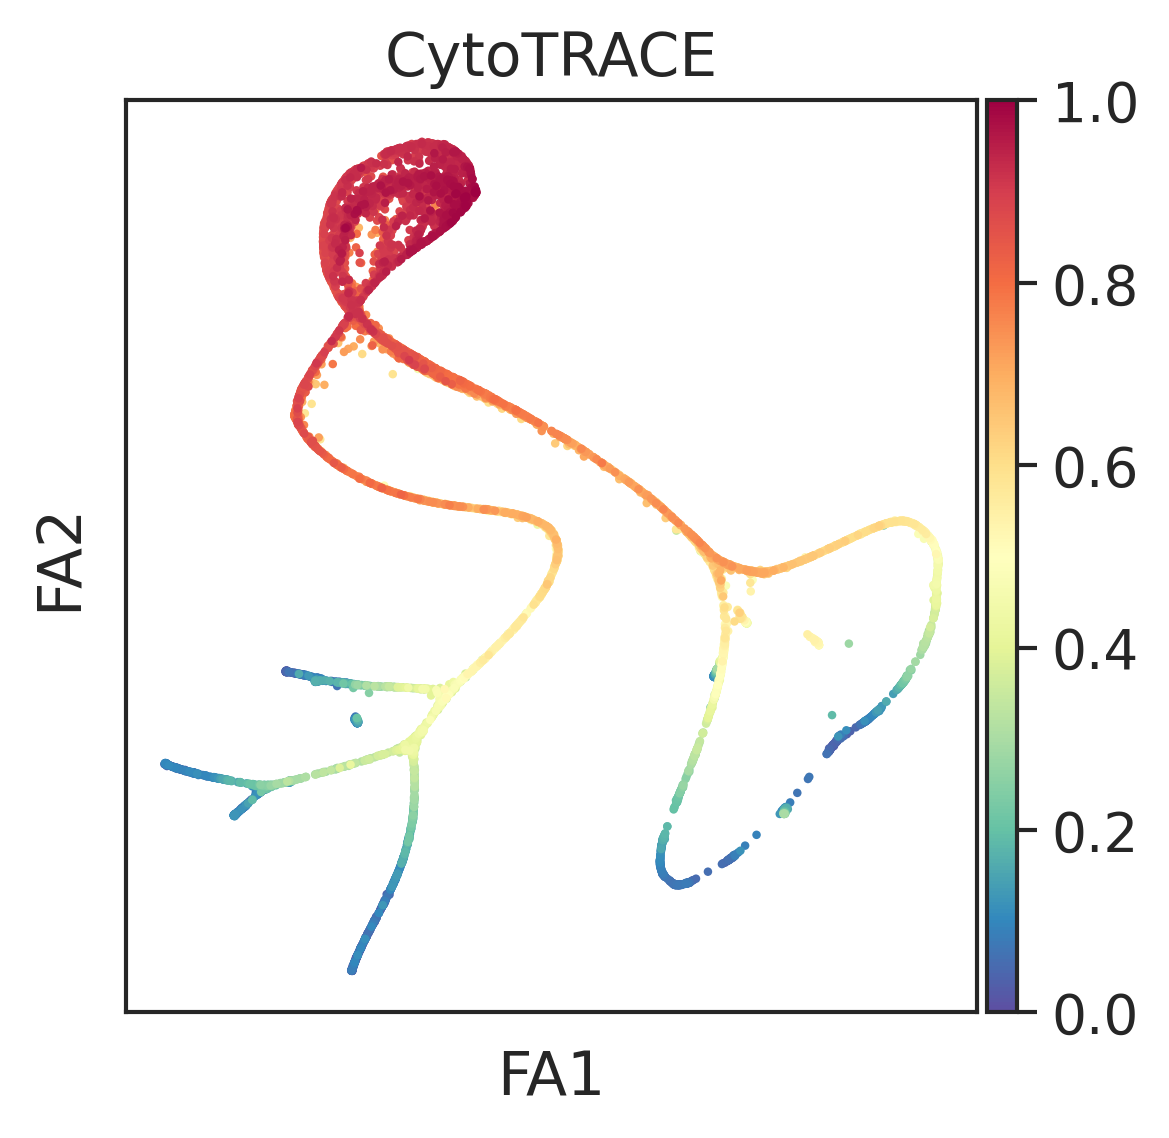

In [31]:
sc.pl.draw_graph(adata,color='CytoTRACE',cmap="Spectral_r")

In [32]:
adata.write("adata_preprocess.h5ad")